# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Автоэнкодер-для-MNIST" data-toc-modified-id="Автоэнкодер-для-MNIST-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Автоэнкодер для MNIST</a></div><div class="lev1 toc-item"><a href="#Загружаем-данные" data-toc-modified-id="Загружаем-данные-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загружаем данные</a></div><div class="lev1 toc-item"><a href="#Создаём-нейросеть" data-toc-modified-id="Создаём-нейросеть-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создаём нейросеть</a></div><div class="lev3 toc-item"><a href="#Определяем-параметры-обучения" data-toc-modified-id="Определяем-параметры-обучения-301"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Определяем параметры обучения</a></div><div class="lev3 toc-item"><a href="#Создаём-функции-обучения-и-тестирования" data-toc-modified-id="Создаём-функции-обучения-и-тестирования-302"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Создаём функции обучения и тестирования</a></div><div class="lev1 toc-item"><a href="#Обучаем-нейросеть" data-toc-modified-id="Обучаем-нейросеть-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучаем нейросеть</a></div><div class="lev1 toc-item"><a href="#Проверяем-правильность-работы-модели" data-toc-modified-id="Проверяем-правильность-работы-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверяем правильность работы модели</a></div>

# Автоэнкодер для MNIST

In [1]:
import os
import sys

import random
import time

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN 5005)


In [3]:
import pickle

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def load_dataset():
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)
        
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
#         return data / np.float32(256)
        return data

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
def build_mlp_autoencoder(input_var=None):
    l_input = lasagne.layers.InputLayer(shape=(None, 784), input_var=input_var)
            
    l_encode = lasagne.layers.DenseLayer(l_input, num_units=32)
    
    l_decode = lasagne.layers.DenseLayer(l_encode, num_units=784)
        
    return l_encode, l_decode

# Загружаем данные

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [8]:
X_train = X_train.reshape((-1, 784))

In [9]:
input_var = T.fmatrix('input_var')

# Создаём нейросеть

In [10]:
l_encode, l_decode = build_mlp_autoencoder(input_var)

### Определяем параметры обучения

In [11]:
prediction = lasagne.layers.get_output(l_decode)

loss = lasagne.objectives.squared_error(prediction, input_var).mean()

params = lasagne.layers.get_all_params(l_decode, trainable=True)

updates = lasagne.updates.adadelta(loss, params)

### Создаём функции обучения и тестирования

In [12]:
train_fn = theano.function([input_var], 
                           loss, 
                           updates=updates, 
                           allow_input_downcast=True)

test_fn = theano.function([input_var], 
                          prediction, 
                          allow_input_downcast=True)

In [13]:
network_output = lasagne.layers.get_output(l_decode)
encoded_output = lasagne.layers.get_output(l_encode)

In [14]:
predict = theano.function([input_var],
                           network_output,
                           allow_input_downcast=True)
encode = theano.function([input_var],
                          encoded_output,
                          allow_input_downcast=True)

In [15]:
def iterate_minibatches(inputs, batchsize, shuffle=False):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [16]:
num_epochs = 50

In [17]:
batch_size = 200

# Обучаем нейросеть

In [18]:
for epoch in range(num_epochs):
    print("Epoch: {}".format(epoch))
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, batch_size, shuffle=True):
        inputs = batch
        train_err += train_fn(inputs)
        train_batches += 1

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


In [19]:
def check_model(x_test, predict, encode):
    encoded_imgs = encode(x_test[:, :])
    decoded_imgs = predict(x_test[:, :])    

    n = 10  # Число обрабатываемых цифр
    plt.figure(figsize=(40, 8))
    for i in range(n):
        # Визуализация исходных изображений
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if (i == n / 2):
            ax.set_title("Original images")

        # Результат с декодировщика
        ax = plt.subplot(3, n, i + n + 1)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if (i == n / 2):
            ax.set_title("Reconstructed images")

        # Результат с кодировщика
        ax = plt.subplot(3, n, i + 2*n + 1)
        plt.imshow(encoded_imgs[i].reshape(4, 8))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if (i == n / 2):
            ax.set_title("Encoded images")

    plt.show()

# Проверяем правильность работы модели

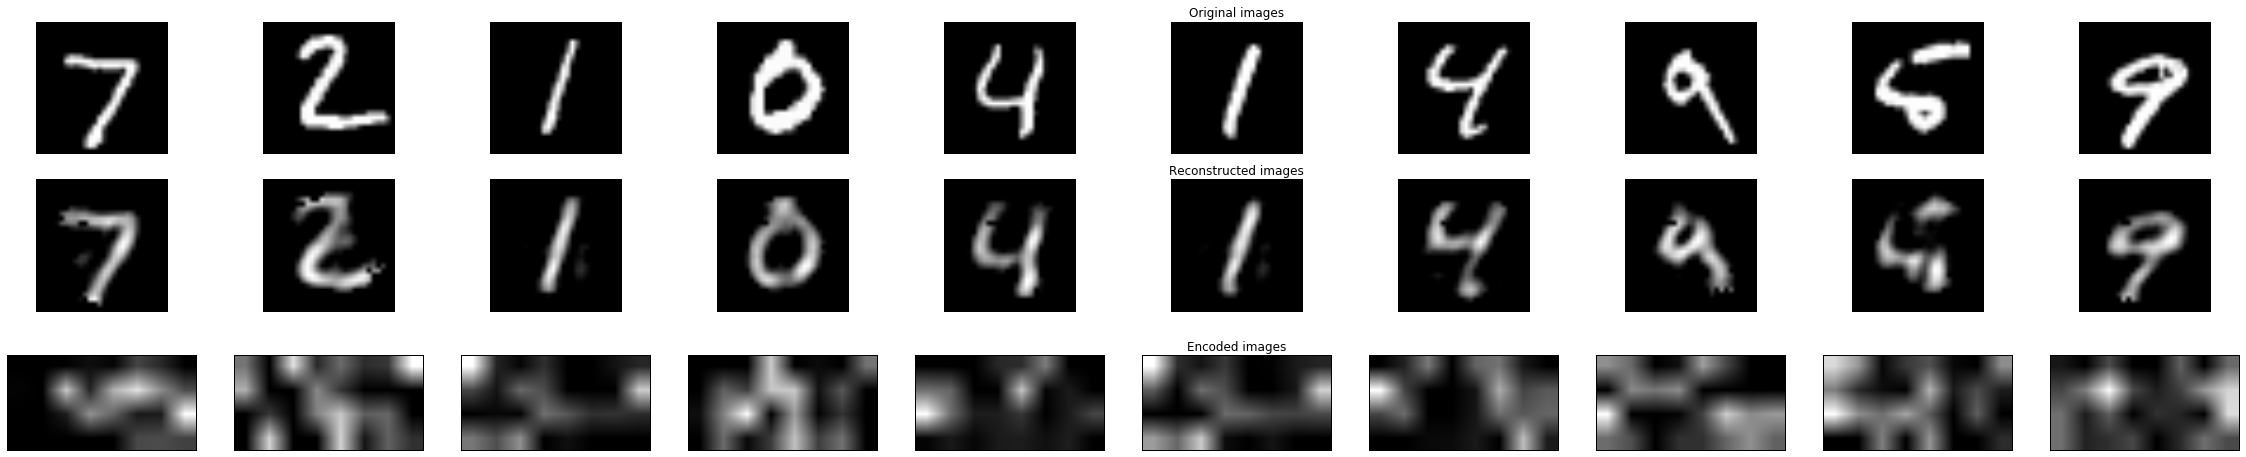

In [20]:
check_model(X_test[:100].reshape((-1,784)), predict, encode)